In [1]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set(color_codes=True)  

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


class DataDistribution(object):
    def __init__(self):
        self.mu = 3
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples


class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01


def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b


def generator(input, h_dim):
    h0 = tf.nn.softplus(linear(input, h_dim, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1


def discriminator(input, h_dim):
    h0 = tf.tanh(linear(input, h_dim * 2, 'd0'))
    h1 = tf.tanh(linear(h0, h_dim * 2, 'd1'))   
    h2 = tf.tanh(linear(h1, h_dim * 2, 'd2'))
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

def optimizer(loss, var_list, initial_learning_rate):
    decay = 0.95
    num_decay_steps = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer


class GAN(object):
    def __init__(self, data, gen, num_steps, batch_size, log_every):
        self.data = data
        self.gen = gen
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.mlp_hidden_size = 4
        self.learning_rate = 0.03
        self._create_model()

    def _create_model(self):

        with tf.variable_scope('D_pre'):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            D_pre = discriminator(self.pre_input, self.mlp_hidden_size)
            self.pre_loss = tf.reduce_mean(tf.square(D_pre - self.pre_labels))
            self.pre_opt = optimizer(self.pre_loss, None, self.learning_rate)

        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('Generator'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = generator(self.z, self.mlp_hidden_size)

        # The discriminator tries to tell the difference between samples from the
        # true data distribution (self.x) and the generated samples (self.z).
        #
        # Here we create two copies of the discriminator network (that share parameters),
        # as you cannot use the same network with different inputs in TensorFlow.
        with tf.variable_scope('Discriminator') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1 = discriminator(self.x, self.mlp_hidden_size)
            scope.reuse_variables()
            self.D2 = discriminator(self.G, self.mlp_hidden_size)

        # Define the loss for discriminator and generator networks (see the original
        # paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1 - self.D2))
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))

        self.d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
        self.d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
        self.g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')

        self.opt_d = optimizer(self.loss_d, self.d_params, self.learning_rate)
        self.opt_g = optimizer(self.loss_g, self.g_params, self.learning_rate)

    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()

            # pretraining discriminator
            num_pretrain_steps = 1000
            for step in range(num_pretrain_steps):
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
                pretrain_loss, _ = session.run([self.pre_loss, self.pre_opt], {
                    self.pre_input: np.reshape(d, (self.batch_size, 1)),
                    self.pre_labels: np.reshape(labels, (self.batch_size, 1))
                })
            self.weightsD = session.run(self.d_pre_params)
            # copy weights from pre-training over to new D network
            for i, v in enumerate(self.d_params):
                session.run(v.assign(self.weightsD[i]))

            for step in range(self.num_steps):
                # update discriminator
                x = self.data.sample(self.batch_size)
                z = self.gen.sample(self.batch_size)
                loss_d, _ = session.run([self.loss_d, self.opt_d], {
                    self.x: np.reshape(x, (self.batch_size, 1)),
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                # update generator
                z = self.gen.sample(self.batch_size)
                loss_g, _ = session.run([self.loss_g, self.opt_g], {
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                if step % self.log_every == 0:
                    print('{}: {}\t{}'.format(step, loss_d, loss_g))                
                if step % 100 == 0 or step==0 or step == self.num_steps -1 :
                    self._plot_distributions(session)

    def _samples(self, session, num_points=10000, num_bins=100):
        xs = np.linspace(-self.gen.range, self.gen.range, num_points)
        bins = np.linspace(-self.gen.range, self.gen.range, num_bins)

        # data distribution
        d = self.data.sample(num_points)
        pd, _ = np.histogram(d, bins=bins, density=True)

        # generated samples
        zs = np.linspace(-self.gen.range, self.gen.range, num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            g[self.batch_size * i:self.batch_size * (i + 1)] = session.run(self.G, {
                self.z: np.reshape(
                    zs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })
        pg, _ = np.histogram(g, bins=bins, density=True)

        return pd, pg

    def _plot_distributions(self, session):
        pd, pg = self._samples(session)
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))
        f, ax = plt.subplots(1)
        ax.set_ylim(0, 1)
        plt.plot(p_x, pd, label='Real Data')
        plt.plot(p_x, pg, label='Generated Data')
        plt.title('GAN Visualization')
        plt.xlabel('Value')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()

def main(args):
    model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        args.num_steps,
        args.batch_size,
        args.log_every,
    )
    model.train()


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--num-steps', type=int, default=1200,
                        help='the number of training steps to take')
    parser.add_argument('--batch-size', type=int, default=12,
                        help='the batch size')
    parser.add_argument('--log-every', type=int, default=10,
                        help='print loss after this many steps')
    parses = parser.parse_args(args=[])#添加args=[]
    return parses


C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0: 0.9058498740196228	3.017925262451172


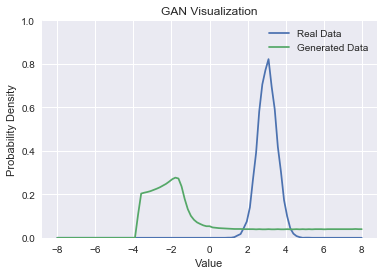

10: 0.3661727011203766	2.4829494953155518
20: 0.2567436695098877	2.527153730392456
30: 0.23893599212169647	2.646153688430786
40: 0.21188394725322723	2.755629301071167
50: 0.24596953392028809	2.7865734100341797
60: 0.27803653478622437	2.819697618484497
70: 0.20561213791370392	3.014293670654297
80: 0.20861400663852692	3.093595266342163
90: 0.1999121755361557	3.1188929080963135
100: 0.8676349520683289	3.1559784412384033


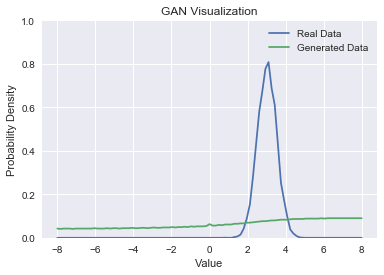

110: 0.2710826098918915	3.0497334003448486
120: 0.2979937791824341	3.3270256519317627
130: 0.35235917568206787	3.153003454208374
140: 0.3312816917896271	3.266500234603882
150: 0.44445013999938965	3.2211639881134033
160: 0.830064594745636	2.5850722789764404
170: 1.0792583227157593	2.844705581665039
180: 1.1153842210769653	2.539602279663086
190: 0.9280094504356384	2.582491636276245
200: 0.8895644545555115	2.544771909713745


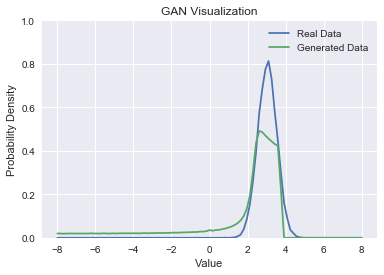

210: 0.8804630637168884	2.5786397457122803
220: 0.9524447321891785	2.5626392364501953
230: 1.0161170959472656	2.6068341732025146
240: 0.9398650527000427	2.61761474609375
250: 0.9690361022949219	2.6562836170196533
260: 0.9535879492759705	2.702772855758667
270: 0.9497044682502747	2.729496955871582
280: 0.9505455493927002	2.7817916870117188
290: 0.9766985774040222	2.822368860244751
300: 0.9790706634521484	2.848435640335083


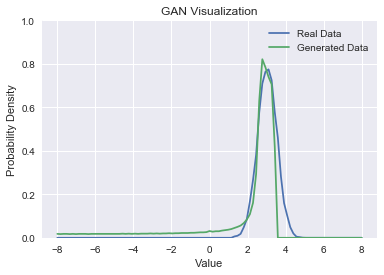

310: 0.9584127068519592	2.831235885620117
320: 0.9558747410774231	2.838682174682617
330: 0.9572162628173828	2.843243360519409
340: 0.9545037150382996	2.8567473888397217
350: 0.9616591930389404	2.8660755157470703
360: 0.9513992667198181	2.8865842819213867
370: 0.9513044953346252	2.8945209980010986
380: 0.9510054588317871	2.9008471965789795
390: 0.9619631767272949	2.911766767501831
400: 0.9593977332115173	2.9199936389923096


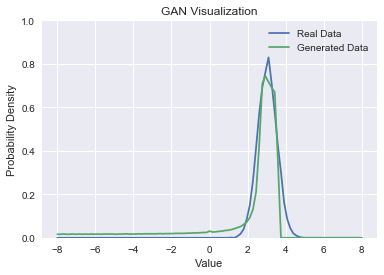

410: 0.9573793411254883	2.925779104232788
420: 0.9600151181221008	2.9308977127075195
430: 0.9554762840270996	2.9343574047088623
440: 0.9505661129951477	2.9468088150024414
450: 0.9538960456848145	2.9457263946533203
460: 0.9585859179496765	2.964500665664673
470: 0.9657346606254578	2.969087600708008
480: 0.9562466740608215	2.97055721282959
490: 0.9631298184394836	2.9682061672210693
500: 0.9579052925109863	2.98766827583313


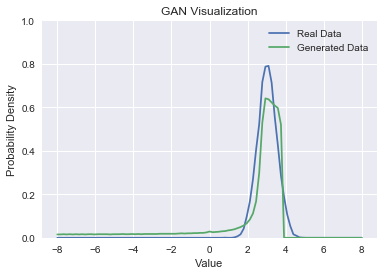

510: 0.9529304504394531	2.9976375102996826
520: 0.9577788710594177	2.9855854511260986
530: 0.9556493759155273	2.9906623363494873
540: 0.963697612285614	3.0012834072113037
550: 0.9546659588813782	3.0135772228240967
560: 0.954541027545929	3.000689744949341
570: 0.9527294635772705	3.018080949783325
580: 0.9562703967094421	3.0316765308380127
590: 0.9562308192253113	3.033099889755249
600: 0.9676775932312012	3.0354459285736084


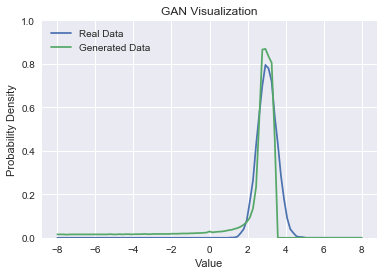

610: 0.9556455612182617	3.026475667953491
620: 0.9621879458427429	3.0372326374053955
630: 0.9544457793235779	3.041356325149536
640: 0.9505367279052734	3.058652877807617
650: 0.9726033210754395	3.0442416667938232
660: 0.960233747959137	3.048086166381836
670: 0.9602031111717224	3.0599300861358643
680: 0.9553996920585632	3.0656583309173584
690: 0.95340496301651	3.061668634414673
700: 0.9558480381965637	3.0625126361846924


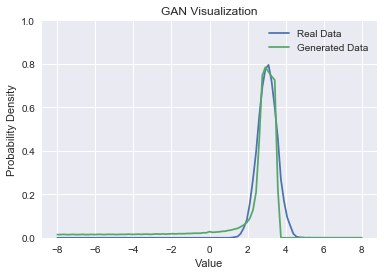

710: 0.9548101425170898	3.0637643337249756
720: 0.9591142535209656	3.0792343616485596
730: 0.9580585360527039	3.076420545578003
740: 0.9542174339294434	3.084198236465454
750: 0.9520791172981262	3.0760724544525146
760: 0.9857081770896912	3.0916473865509033
770: 0.954762876033783	3.098372220993042
780: 0.956782341003418	3.101635694503784
790: 0.9556240439414978	3.0913455486297607
800: 0.9452716708183289	3.0873405933380127


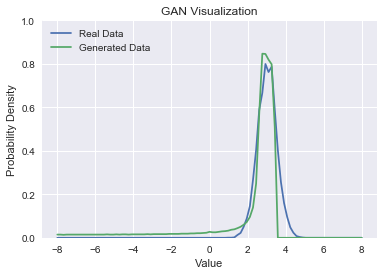

810: 0.9598703384399414	3.0957539081573486
820: 0.9495179057121277	3.1218841075897217
830: 0.9676353335380554	3.1136913299560547
840: 0.9608518481254578	3.0985374450683594
850: 0.9497320055961609	3.1004221439361572
860: 0.9583330750465393	3.10925030708313
870: 0.9575583338737488	3.115415573120117
880: 0.9481444954872131	3.142063856124878
890: 0.9595341086387634	3.1321611404418945
900: 0.9526324272155762	3.115969657897949


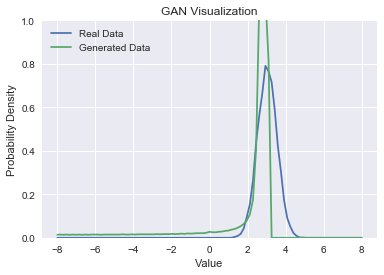

910: 0.957833468914032	3.1158668994903564
920: 0.9581219553947449	3.13159441947937
930: 0.9586291313171387	3.1408939361572266
940: 0.9535805583000183	3.152231454849243
950: 0.9539173245429993	3.1291332244873047
960: 0.9537625312805176	3.130748748779297
970: 0.9528759121894836	3.1425857543945312
980: 0.9532210230827332	3.150545835494995
990: 0.9515659213066101	3.157489776611328
1000: 0.9518685936927795	3.140913724899292


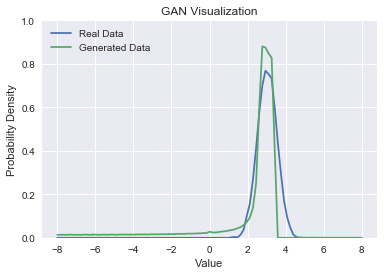

1010: 0.9496883749961853	3.143315315246582
1020: 0.9560754895210266	3.156165361404419
1030: 0.9554839134216309	3.1636600494384766
1040: 0.9747700095176697	3.1666743755340576
1050: 0.9559829235076904	3.1536171436309814
1060: 0.9466338753700256	3.153604507446289
1070: 0.9512701034545898	3.1573095321655273
1080: 0.9531095623970032	3.1709377765655518
1090: 0.9690462946891785	3.1741015911102295
1100: 0.9565709233283997	3.173053026199341


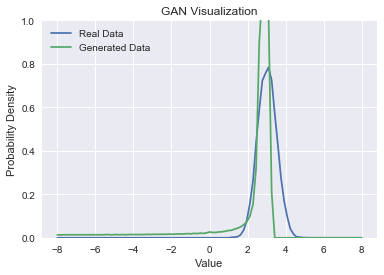

1110: 0.9528694748878479	3.1647026538848877
1120: 0.9897692799568176	3.173391342163086
1130: 0.9538822770118713	3.1752426624298096
1140: 0.9539585709571838	3.1887900829315186
1150: 0.9726629257202148	3.1818549633026123
1160: 0.9535603523254395	3.177844285964966
1170: 0.9504902958869934	3.1759109497070312
1180: 0.9564926028251648	3.1849753856658936
1190: 0.9527941346168518	3.2040793895721436


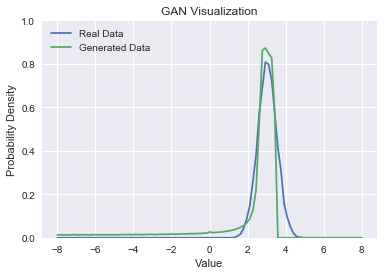

In [2]:
if __name__ == '__main__':
    main(parse_args())

## 1、导入相关包，设置随机参数

In [1]:
import argparse
import numpy as np
from scipy.stats import norm
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

sns.set(color_codes=True)  

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

C:\Users\adward\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2、设置真实数据的分布、生成器的初始化分布

In [2]:
# 均值为3，方差为0.5的高斯分布
class DataDistribution(object):
    def __init__(self):
        self.mu = 3
        self.sigma = 0.5

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples

# 生成器初始分布为平均分布
class GeneratorDistribution(object):
    def __init__(self, range):
        self.range = range

    def sample(self, N):
        return np.linspace(-self.range, self.range, N) + \
            np.random.random(N) * 0.01

## 3、设置线性运算：并用于生成器和判别器

In [3]:
def linear(input, output_dim, scope=None, stddev=1.0):
    norm = tf.random_normal_initializer(stddev=stddev)
    const = tf.constant_initializer(0.0)
    with tf.variable_scope(scope or 'linear'):
        w = tf.get_variable('w', [input.get_shape()[1], output_dim], initializer=norm)
        b = tf.get_variable('b', [output_dim], initializer=const)
        return tf.matmul(input, w) + b


def generator(input, h_dim):
    h0 = tf.nn.softplus(linear(input, h_dim, 'g0'))
    h1 = linear(h0, 1, 'g1')
    return h1


def discriminator(input, h_dim):
    h0 = tf.tanh(linear(input, h_dim * 2, 'd0'))
    h1 = tf.tanh(linear(h0, h_dim * 2, 'd1'))   
    h2 = tf.tanh(linear(h1, h_dim * 2, 'd2'))
    h3 = tf.sigmoid(linear(h2, 1, 'd3'))
    return h3

## 4、设置优化器，使用学习率衰减的梯度下降方法

In [4]:
def optimizer(loss, var_list, initial_learning_rate):
    decay = 0.95
    num_decay_steps = 150
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

## 5、搭建GAN模型

In [5]:
class GAN(object):
    def __init__(self, data, gen, num_steps, batch_size, log_every):
        self.data = data
        self.gen = gen
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.log_every = log_every
        self.mlp_hidden_size = 4
        self.learning_rate = 0.03
        self._create_model()

    def _create_model(self):

        with tf.variable_scope('D_pre'):
            self.pre_input = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.pre_labels = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            D_pre = discriminator(self.pre_input, self.mlp_hidden_size)
            self.pre_loss = tf.reduce_mean(tf.square(D_pre - self.pre_labels))
            self.pre_opt = optimizer(self.pre_loss, None, self.learning_rate)

        # This defines the generator network - it takes samples from a noise
        # distribution as input, and passes them through an MLP.
        with tf.variable_scope('Generator'):
            self.z = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.G = generator(self.z, self.mlp_hidden_size)

        # The discriminator tries to tell the difference between samples from the
        # true data distribution (self.x) and the generated samples (self.z).
        #
        # Here we create two copies of the discriminator network (that share parameters),
        # as you cannot use the same network with different inputs in TensorFlow.
        with tf.variable_scope('Discriminator') as scope:
            self.x = tf.placeholder(tf.float32, shape=(self.batch_size, 1))
            self.D1 = discriminator(self.x, self.mlp_hidden_size)
            scope.reuse_variables()
            self.D2 = discriminator(self.G, self.mlp_hidden_size)

        # Define the loss for discriminator and generator networks (see the original
        # paper for details), and create optimizers for both
        self.loss_d = tf.reduce_mean(-tf.log(self.D1) - tf.log(1 - self.D2))
        self.loss_g = tf.reduce_mean(-tf.log(self.D2))

        self.d_pre_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='D_pre')
        self.d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
        self.g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')

        self.opt_d = optimizer(self.loss_d, self.d_params, self.learning_rate)
        self.opt_g = optimizer(self.loss_g, self.g_params, self.learning_rate)

    def train(self):
        with tf.Session() as session:
            tf.global_variables_initializer().run()

            # pretraining discriminator
            num_pretrain_steps = 1000
            for step in range(num_pretrain_steps):
                d = (np.random.random(self.batch_size) - 0.5) * 10.0
                labels = norm.pdf(d, loc=self.data.mu, scale=self.data.sigma)
                pretrain_loss, _ = session.run([self.pre_loss, self.pre_opt], {
                    self.pre_input: np.reshape(d, (self.batch_size, 1)),
                    self.pre_labels: np.reshape(labels, (self.batch_size, 1))
                })
            self.weightsD = session.run(self.d_pre_params)
            # copy weights from pre-training over to new D network
            for i, v in enumerate(self.d_params):
                session.run(v.assign(self.weightsD[i]))

            for step in range(self.num_steps):
                # update discriminator
                x = self.data.sample(self.batch_size)
                z = self.gen.sample(self.batch_size)
                loss_d, _ = session.run([self.loss_d, self.opt_d], {
                    self.x: np.reshape(x, (self.batch_size, 1)),
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                # update generator
                z = self.gen.sample(self.batch_size)
                loss_g, _ = session.run([self.loss_g, self.opt_g], {
                    self.z: np.reshape(z, (self.batch_size, 1))
                })

                if step % self.log_every == 0:
                    print('{}: {}\t{}'.format(step, loss_d, loss_g))                
                if step % 100 == 0 or step==0 or step == self.num_steps -1 :
                    self._plot_distributions(session)

    def _samples(self, session, num_points=10000, num_bins=100):
        xs = np.linspace(-self.gen.range, self.gen.range, num_points)
        bins = np.linspace(-self.gen.range, self.gen.range, num_bins)

        # data distribution
        d = self.data.sample(num_points)
        pd, _ = np.histogram(d, bins=bins, density=True)

        # generated samples
        zs = np.linspace(-self.gen.range, self.gen.range, num_points)
        g = np.zeros((num_points, 1))
        for i in range(num_points // self.batch_size):
            g[self.batch_size * i:self.batch_size * (i + 1)] = session.run(self.G, {
                self.z: np.reshape(
                    zs[self.batch_size * i:self.batch_size * (i + 1)],
                    (self.batch_size, 1)
                )
            })
        pg, _ = np.histogram(g, bins=bins, density=True)

        return pd, pg

    def _plot_distributions(self, session):
        pd, pg = self._samples(session)
        p_x = np.linspace(-self.gen.range, self.gen.range, len(pd))
        f, ax = plt.subplots(1)
        ax.set_ylim(0, 1)
        plt.plot(p_x, pd, label='Real Data')
        plt.plot(p_x, pg, label='Generated Data')
        plt.title('GAN Visualization')
        plt.xlabel('Value')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.show()

## 6、运行主程序

In [6]:
def main(args):
    model = GAN(
        DataDistribution(),
        GeneratorDistribution(range=8),
        args.num_steps,
        args.batch_size,
        args.log_every,
    )
    model.train()


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--num-steps', type=int, default=1200,
                        help='the number of training steps to take')
    parser.add_argument('--batch-size', type=int, default=12,
                        help='the batch size')
    parser.add_argument('--log-every', type=int, default=10,
                        help='print loss after this many steps')
    parses = parser.parse_args(args=[])#添加args=[]
    return parses

In [ ]:
if __name__ == '__main__':
    main(parse_args())